In [ ]:
import os
import re
import gc
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity
import ruptures as rpt
from transformers import AutoTokenizer, AutoModel

d:\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Config

In [ ]:
DATA_PATH = "yelp_academic_dataset_review.json"  
MIN_REVIEWS_PER_USER = 30
MAX_REVIEWS_PER_USER = 200
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

Using device: cuda


### Low-memory preprocessing for yelp json

In [ ]:

CHUNK_SIZE = 100_000
MIN_REVIEWS_PER_USER = 30

cols = ['user_id', 'stars', 'text', 'date']
cleaned_chunks = []
user_review_counts = {}

print("Counting user review frequencies (light scan)...")
with pd.read_json(DATA_PATH, lines=True, chunksize=CHUNK_SIZE) as reader:
    for chunk in tqdm(reader):
        counts = chunk['user_id'].value_counts()
        for uid, c in counts.items():
            user_review_counts[uid] = user_review_counts.get(uid, 0) + c

valid_users = {uid for uid, c in user_review_counts.items() if c >= MIN_REVIEWS_PER_USER}
print(f"Found {len(valid_users)} active users.")

def clean_text(t):
    t = str(t).lower()
    t = re.sub(r"http\S+|www\S+", "", t)
    t = re.sub(r"[^a-z0-9\s.,!?']", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

print("Filtering & cleaning active-user reviews...")
with pd.read_json(DATA_PATH, lines=True, chunksize=CHUNK_SIZE) as reader:
    for chunk in tqdm(reader):
        chunk = chunk[cols]
        chunk = chunk[chunk['user_id'].isin(valid_users)]
        if chunk.empty:
            continue
        chunk['date'] = pd.to_datetime(chunk['date'], errors='coerce')
        chunk = chunk.dropna(subset=['date'])
        chunk['clean_text'] = chunk['text'].apply(clean_text)
        cleaned_chunks.append(chunk)

df = pd.concat(cleaned_chunks, ignore_index=True)
print(f"✅ Retained {len(df):,} reviews across {df['user_id'].nunique()} active users.")

df['rating_norm'] = (df['stars'] - 3) / 2
df = df.sort_values(['user_id', 'date'])
df['time_since_start'] = (
    df['date'] - df.groupby('user_id')['date'].transform('min')
).dt.days

print("Preprocessing complete; DataFrame in memory ready for embeddings.")

Counting user review frequencies (light scan)...


0it [00:00, ?it/s]

70it [02:38,  2.26s/it]


Found 25540 active users.
Filtering & cleaning active-user reviews...


70it [05:01,  4.31s/it]


✅ Retained 1,888,035 reviews across 25540 active users.
Preprocessing complete; DataFrame in memory ready for embeddings.


### Load distilbert model

In [ ]:
print("\n🔧 Loading DistilBERT model...")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased").to(DEVICE)
model.eval()
print("✅ Model loaded.")

### Gpu-optimized embedding function

In [ ]:
def get_batch_embeddings(text_batch, tokenizer, model, device):
    """Compute mean-pooled DistilBERT embeddings for a batch of texts (stay on GPU)."""
    encoded = tokenizer(
        text_batch,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    encoded = {k: v.to(device, non_blocking=True) for k, v in encoded.items()}

    with torch.no_grad():
        outputs = model(**encoded)
        embeddings = outputs.last_hidden_state.mean(dim=1)

    return embeddings

In [ ]:
sample_users = (
    df['user_id'].value_counts()[lambda x: x >= 50]
    .sample(1000, random_state=42)
    .index
)

df_sample = df[df['user_id'].isin(sample_users)].reset_index(drop=True)

print(f"✅ Sample subset: {len(df_sample):,} reviews from {len(sample_users)} users.")

✅ Sample subset: 115,213 reviews from 1000 users.


In [ ]:
BATCH_SIZE = 16
all_embeddings_gpu = []

texts = df_sample['clean_text'].tolist()
n = len(texts)
print(f"🔍 Computing embeddings for {n:,} sample reviews...")

for i in tqdm(range(0, n, BATCH_SIZE), desc="Encoding batches"):
    batch_texts = texts[i:i+BATCH_SIZE]
    batch_emb = get_batch_embeddings(batch_texts, tokenizer, model, DEVICE)
    all_embeddings_gpu.append(batch_emb)

embeddings_gpu = torch.cat(all_embeddings_gpu, dim=0)
embeddings_gpu = torch.nn.functional.normalize(embeddings_gpu, p=2, dim=1)

embeddings = embeddings_gpu.cpu().numpy()
df_sample['embedding'] = list(embeddings)

print(f"✅ Done! Computed {embeddings.shape[0]} embeddings "
      f"on device {DEVICE} for {len(sample_users)} users.")

del all_embeddings_gpu, embeddings_gpu
torch.cuda.empty_cache()
gc.collect()

🔍 Computing embeddings for 115,213 sample reviews...


Encoding batches: 100%|██████████| 7201/7201 [03:53<00:00, 30.86it/s]


✅ Done! Computed 115213 embeddings on device cuda for 1000 users.


20

In [ ]:
for user_id in df_sample['user_id'].unique():
    u_df = df_sample[df_sample['user_id'] == user_id]
    print(user_id, len(u_df), "reviews")

-7XrSrJfHndHc_taEXurTw 190 reviews
-AwZjQNFpCqc0bVNNyBqwg 66 reviews
-FxsSuwDbIII7yo5BjHpiA 399 reviews
-Her419l4DCjSFey7UjmtA 102 reviews
-NXMmOULp-kUv_LO1V6JVQ 55 reviews
-NycZLw5rPxqwrkKKI-83w 109 reviews
-Oyi4dDuax3yGa-Pnyf9jg 50 reviews
-R6dgi_HAYvj9e4FH7NTlQ 65 reviews
-TcZ82WJnqdH9CbTuxuU6Q 54 reviews
-UTLoE7X7EiXD5Vy_Hmcew 54 reviews
-V7frksbFjKQYVhrPnnlPw 458 reviews
-Wu93nlWpC56t8_0IHs4UQ 65 reviews
-X1DtcndHvtoFkVsZZLsFg 57 reviews
-b3giTuADjiihFgGDvlWCw 69 reviews
-frybFHNHWnwd69LFXkOVQ 202 reviews
-imdPiD9l7cS-x1jEDAS-w 151 reviews
-muNAYCmylCP7kype-VCZA 140 reviews
-ne-7caCLAk2j3kD7tzBGw 229 reviews
-uJaPhoNXikYWsb0xC09_A 52 reviews
-vPtYuV_dMPb0Bbzg9ECVw 141 reviews
-y4O_E79Z6QwEI1p4OU_0w 189 reviews
005GchcM1HWBH3SFKrIxBA 176 reviews
0Bu7_bXX4dCssG0-OWd_jQ 179 reviews
0Ce-iZttI9NFAuQJ1qWsBw 77 reviews
0DB3Irpf_ETVXu_Ou9vPow 611 reviews
0DTU4p5XHRrsHnHmAsqwnQ 84 reviews
0ENd1AIvSuHjpxZmGE7WEw 75 reviews
0EzVaafewdhxnn0i2WR5lA 69 reviews
0Hl2BwAIz3Gi3Jhlx7AYZA 289 reviews

In [ ]:
print(df_sample.columns)
print(df_sample.head(3))

Index(['user_id', 'stars', 'text', 'date', 'clean_text', 'rating_norm',
       'time_since_start', 'embedding'],
      dtype='object')
                  user_id  stars  \
0  -7XrSrJfHndHc_taEXurTw      5   
1  -7XrSrJfHndHc_taEXurTw      5   
2  -7XrSrJfHndHc_taEXurTw      5   

                                                text                date  \
0  The dog park and dog beach are terrific.  No l... 2014-07-12 16:52:24   
1  Jet City is a charming Coffee House located in... 2014-07-27 17:13:24   
2  If you are going to spend any time in ybor cit... 2014-07-27 17:26:45   

                                          clean_text  rating_norm  \
0  the dog park and dog beach are terrific. no le...          1.0   
1  jet city is a charming coffee house located in...          1.0   
2  if you are going to spend any time in ybor cit...          1.0   

   time_since_start                                          embedding  
0                 0  [0.0025602053, 0.0060909833, 0.027790288, 0.

### Display feature vector representation

In [ ]:
import numpy as np
from pprint import pprint

feature_cols = ['user_id', 'date', 'time_since_start', 'rating_norm', 'embedding']

sample_row = df_sample.iloc[0]
print("🧠 Example feature vector structure:")
print(f"User ID: {sample_row['user_id']}")
print(f"Date: {sample_row['date']}")
print(f"Relative Time (days): {sample_row['time_since_start']}")
print(f"Normalized Rating: {sample_row['rating_norm']:.3f}")
print(f"Embedding Shape: {len(sample_row['embedding'])} dimensions")

print("\n🔢 First 10 values of embedding vector:")
pprint(sample_row['embedding'][:10])

display_df = df_sample[['user_id', 'time_since_start', 'rating_norm']].copy()
display_df['embedding_dim1'] = df_sample['embedding'].apply(lambda x: x[0])
display_df['embedding_dim2'] = df_sample['embedding'].apply(lambda x: x[1])
display_df['embedding_dim3'] = df_sample['embedding'].apply(lambda x: x[2])

print("\n✅ Simplified view of feature vector DataFrame (first few rows):")
print(display_df.head())

🧠 Example feature vector structure:
User ID: -7XrSrJfHndHc_taEXurTw
Date: 2014-07-12 16:52:24
Relative Time (days): 0
Normalized Rating: 1.000
Embedding Shape: 768 dimensions

🔢 First 10 values of embedding vector:
array([ 0.00256021,  0.00609098,  0.02779029,  0.03420174,  0.06145985,
       -0.04989517, -0.0008149 ,  0.05867576, -0.01705415, -0.02279871],
      dtype=float32)

✅ Simplified view of feature vector DataFrame (first few rows):
                  user_id  time_since_start  rating_norm  embedding_dim1  \
0  -7XrSrJfHndHc_taEXurTw                 0          1.0        0.002560   
1  -7XrSrJfHndHc_taEXurTw                15          1.0       -0.008548   
2  -7XrSrJfHndHc_taEXurTw                15          1.0       -0.003094   
3  -7XrSrJfHndHc_taEXurTw                15          1.0       -0.020696   
4  -7XrSrJfHndHc_taEXurTw                19          0.5        0.000250   

   embedding_dim2  embedding_dim3  
0        0.006091        0.027790  
1       -0.001849        

In [ ]:
print("\n📊 Performing user-level drift analysis...")

def analyze_user_drift(user_id, df, penalty=1.0):
    """Compute sentiment slope, change-points, and semantic drift per user."""
    u_df = df[df['user_id'] == user_id].sort_values('date')
    if len(u_df) < MIN_REVIEWS_PER_USER:
        return None

    u_df = u_df.iloc[:MAX_REVIEWS_PER_USER]

    X = u_df[['time_since_start']].values
    y = u_df['rating_norm'].values
    lr = LinearRegression().fit(X, y)
    slope = lr.coef_[0]

    algo = rpt.Pelt(model="rbf").fit(y)
    changepoints = algo.predict(pen=penalty)[:-1]

    e_first = np.array(u_df['embedding'].iloc[0])
    e_last = np.array(u_df['embedding'].iloc[-1])
    sem_drift = 1 - cosine_similarity([e_first], [e_last])[0, 0]

    return {
        "user_id": user_id,
        "n_reviews": len(u_df),
        "slope": slope,
        "total_rating_change": y[-1] - y[0],
        "n_changepoints": len(changepoints),
        "changepoints": changepoints,
        "semantic_drift": sem_drift,
        "dates": list(u_df['date']),
        "ratings": list(y)
    }

results = []
for uid in tqdm(df['user_id'].unique(), desc="Analyzing users"):
    r = analyze_user_drift(uid, df_sample)
    if r: results.append(r)

drift_df = pd.DataFrame(results)
print(f"✅ Drift computed for {len(drift_df)} users")


📊 Performing user-level drift analysis...


Analyzing users: 100%|██████████| 25540/25540 [14:54<00:00, 28.55it/s]


✅ Drift computed for 1000 users


### Visualization

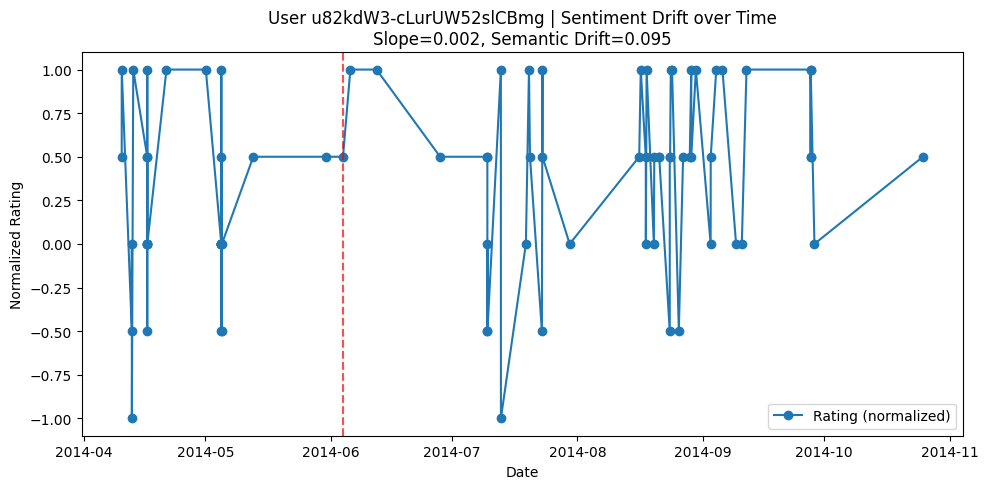

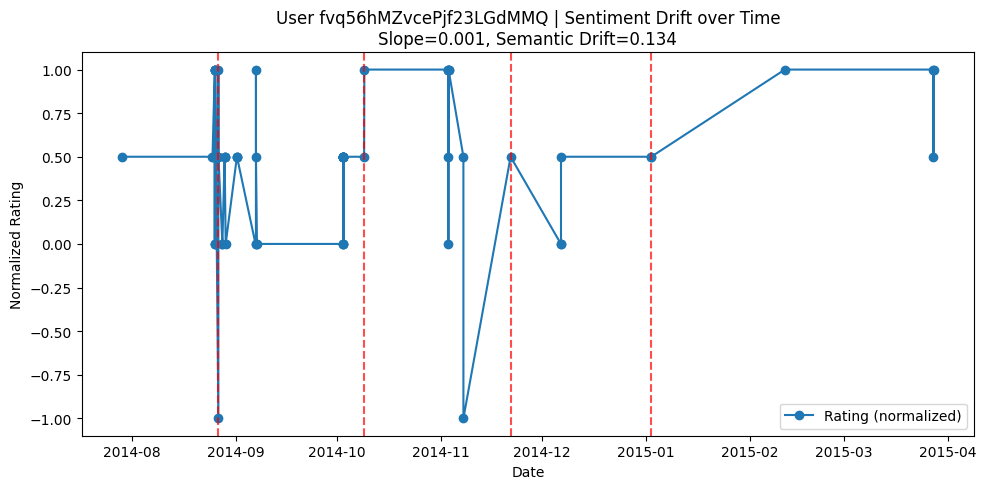


📁 Saved user drift summary to 'user_drift_summary.csv'
✅ Pipeline complete!


In [ ]:
def plot_user_drift(user_id, df, drift_df):
    u_df = df[df['user_id'] == user_id].sort_values('date')
    drift_info = drift_df.loc[drift_df['user_id'] == user_id].iloc[0]

    plt.figure(figsize=(10, 5))
    plt.plot(u_df['date'], u_df['rating_norm'], marker='o', label='Rating (normalized)')
    for cp in drift_info['changepoints']:
        if cp < len(u_df):
            plt.axvline(u_df['date'].iloc[cp], color='red', linestyle='--', alpha=0.7)
    plt.title(f"User {user_id} | Sentiment Drift over Time\nSlope={drift_info['slope']:.3f}, "
              f"Semantic Drift={drift_info['semantic_drift']:.3f}")
    plt.xlabel("Date")
    plt.ylabel("Normalized Rating")
    plt.legend()
    plt.tight_layout()
    plt.show()

top_users = drift_df.sort_values('slope', ascending=False).head(2)['user_id'].tolist()
for u in top_users:
    plot_user_drift(u, df, drift_df)

# Save Results
drift_df.to_csv("user_drift_summary.csv", index=False)
print("\n📁 Saved user drift summary to 'user_drift_summary.csv'")
print("✅ Pipeline complete!")

### Combined drift score + top user visualization

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import ruptures as rpt

def compute_user_drift(user_id, df):
    """Compute overall sentiment & semantic drift summary for one user."""
    u_df = df[df['user_id'] == user_id].sort_values('date')
    if len(u_df) < 3:
        return None

    X = u_df[['time_since_start']].values
    y = u_df['rating_norm'].values
    slope = LinearRegression().fit(X, y).coef_[0]
    total_change = y[-1] - y[0]

    E = np.vstack(u_df['embedding'].values)
    sim_long = cosine_similarity(E[:1], E[-1:])[0,0]
    sem_drift_long = float(1 - sim_long)

    algo = rpt.Pelt(model="rbf").fit(y)
    changepoints = algo.predict(pen=1.0)[:-1]

    drift_score = 0.6 * abs(total_change) + 0.4 * sem_drift_long

    return {
        "user_id": user_id,
        "n_reviews": len(u_df),
        "slope": slope,
        "total_rating_change": total_change,
        "semantic_drift_long": sem_drift_long,
        "drift_score": drift_score,
        "changepoints": changepoints
    }

user_summaries = []
for uid in df_sample['user_id'].unique():
    summary = compute_user_drift(uid, df_sample)
    if summary:
        user_summaries.append(summary)

drift_summary_df = pd.DataFrame(user_summaries)
drift_summary_df = drift_summary_df.sort_values('drift_score', ascending=False).reset_index(drop=True)

print("✅ Drift summary computed!")
print(drift_summary_df[['user_id','n_reviews','slope','total_rating_change','semantic_drift_long','drift_score']].head())

✅ Drift summary computed!
                  user_id  n_reviews     slope  total_rating_change  \
0  KRNbW2TCluXsd8VtNJ8uew        197 -0.000006                  2.0   
1  zwJ0JCd6onxHPyywDrTLtg         69 -0.000117                 -2.0   
2  I2IcL6kGmTgpj8BA3JAjIA         61 -0.000668                 -2.0   
3  olXEpml_LfisIvolB6TRYw         92 -0.000014                  2.0   
4  DL--S3W0-kR-YopomPn7wg         79  0.000282                  2.0   

   semantic_drift_long  drift_score  
0             0.298123     1.319249  
1             0.281310     1.312524  
2             0.266661     1.306664  
3             0.253509     1.301404  
4             0.252970     1.301188  


### Plot Top-K Drifting Users


📊 Displaying top 5 drifting users by drift_score...



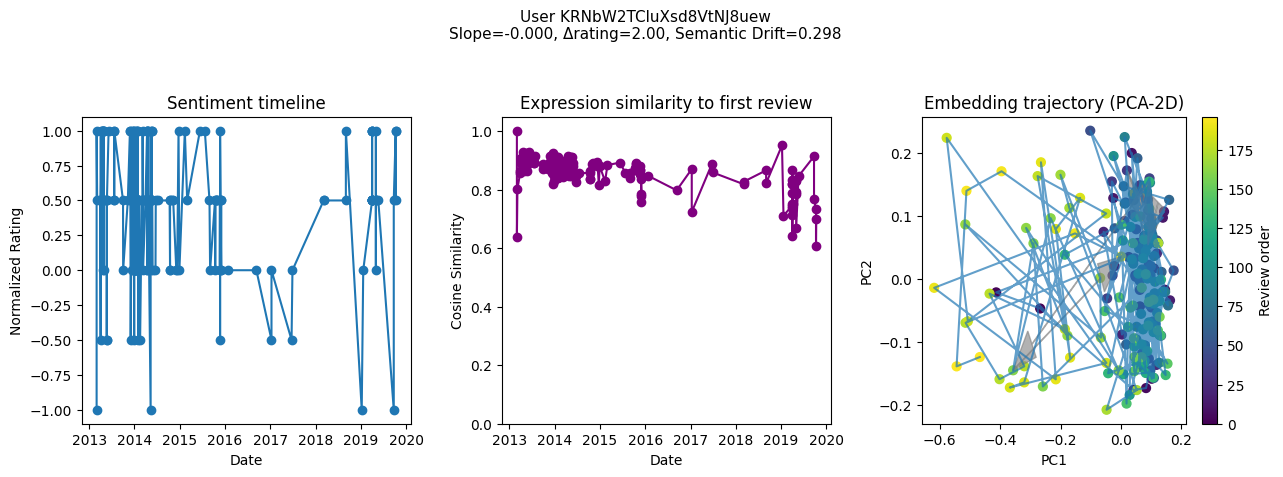

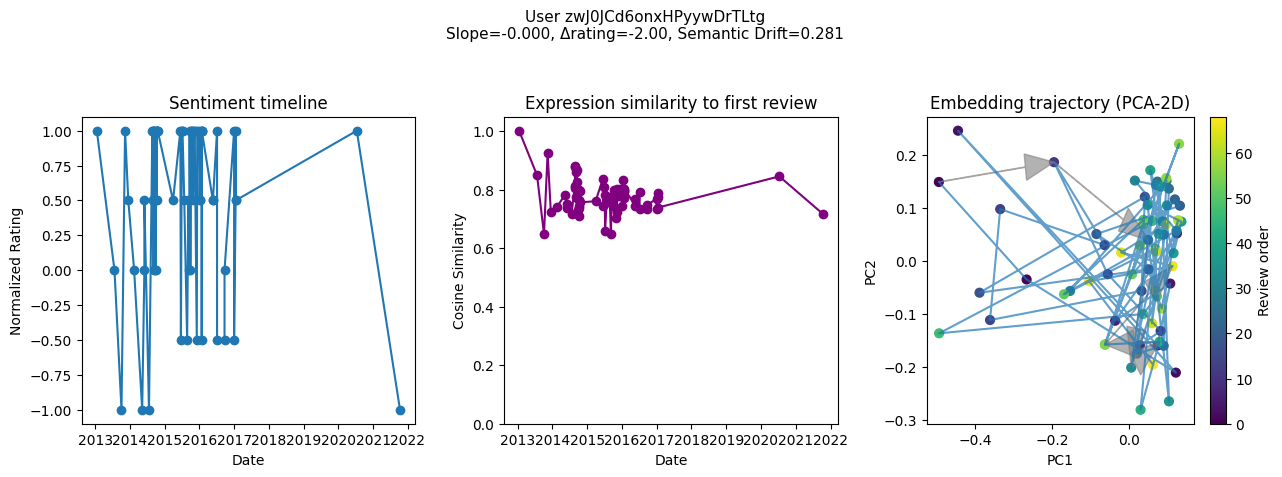

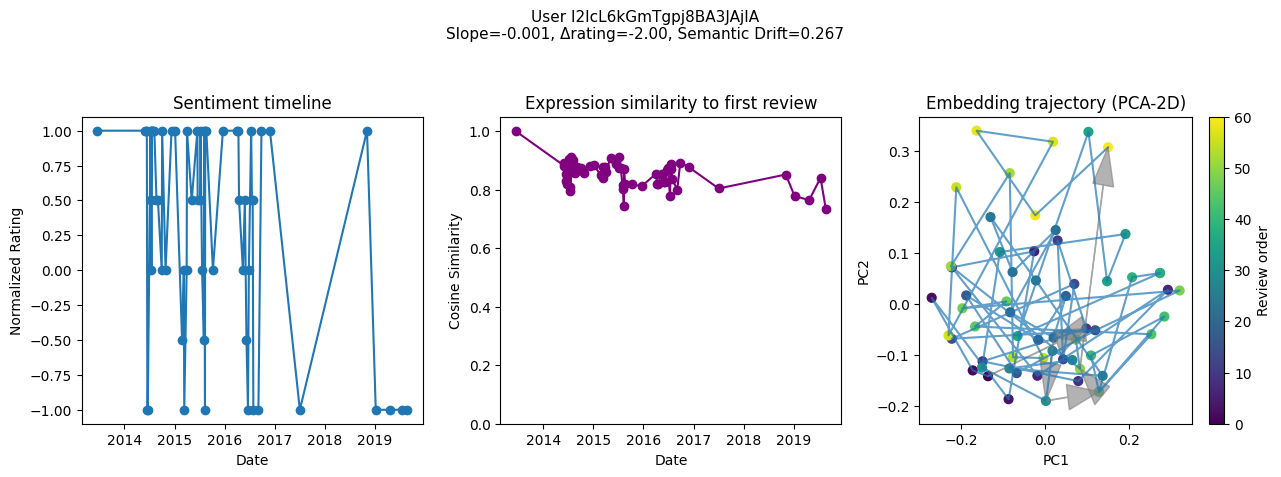

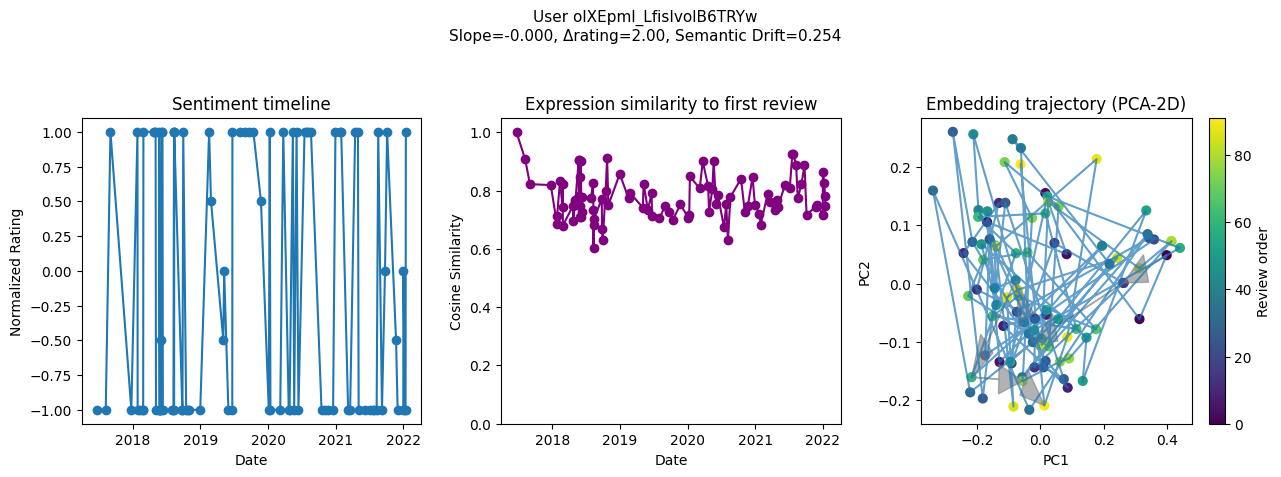

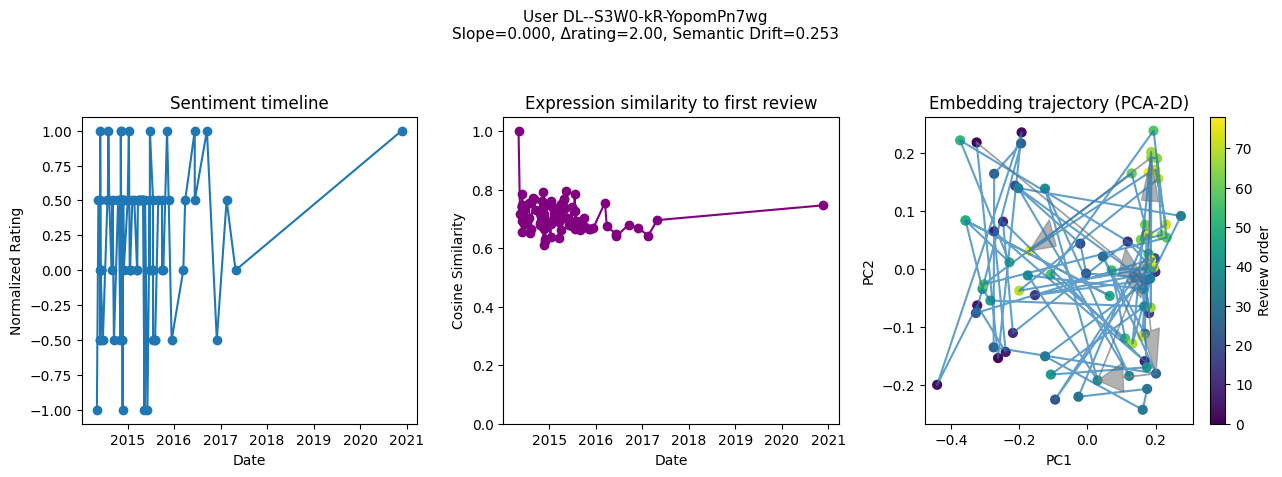

In [ ]:
def plot_user_drift_dashboard(user_id, df):
    """Plots 3 panels: rating timeline, similarity-to-first, PCA trajectory."""
    u = df[df['user_id'] == user_id].sort_values('date').reset_index(drop=True)

    X = u[['time_since_start']].values
    y = u['rating_norm'].values
    slope = LinearRegression().fit(X, y).coef_[0]
    total_change = y[-1] - y[0]

    E = np.vstack(u['embedding'].values)
    sim_to_first = cosine_similarity(E, E[0:1]).ravel()
    sim_long = cosine_similarity(E[:1], E[-1:])[0,0]
    sem_drift_long = float(1 - sim_long)

    pca = PCA(n_components=2)
    Z = pca.fit_transform(E)

    fig, axes = plt.subplots(1, 3, figsize=(13, 4.5))
    fig.suptitle(f"User {user_id}\nSlope={slope:.3f}, Δrating={total_change:.2f}, "
                 f"Semantic Drift={sem_drift_long:.3f}", fontsize=11, y=1.05)

    axes[0].plot(u['date'], y, marker='o')
    axes[0].set_title("Sentiment timeline")
    axes[0].set_xlabel("Date"); axes[0].set_ylabel("Normalized Rating")

    axes[1].plot(u['date'], sim_to_first, marker='o', color='purple')
    axes[1].set_ylim(0, 1.05)
    axes[1].set_title("Expression similarity to first review")
    axes[1].set_xlabel("Date"); axes[1].set_ylabel("Cosine Similarity")

    sc = axes[2].scatter(Z[:,0], Z[:,1], c=np.arange(len(Z)), cmap='viridis', s=40)
    axes[2].plot(Z[:,0], Z[:,1], alpha=0.7)
    step = max(1, len(Z)//6)
    for i in range(0, len(Z)-step, step):
        dx, dy = Z[i+step,0]-Z[i,0], Z[i+step,1]-Z[i,1]
        axes[2].arrow(Z[i,0], Z[i,1], dx, dy, head_width=0.05,
                      length_includes_head=True, color='gray', alpha=0.6)
    axes[2].set_title("Embedding trajectory (PCA-2D)")
    axes[2].set_xlabel("PC1"); axes[2].set_ylabel("PC2")

    fig.colorbar(sc, ax=axes[2], orientation='vertical', label='Review order')
    fig.tight_layout()
    plt.show()

TOP_K = 5
print(f"\n📊 Displaying top {TOP_K} drifting users by drift_score...\n")

for uid in drift_summary_df.head(TOP_K)['user_id']:
    plot_user_drift_dashboard(uid, df_sample)

In [ ]:
import os, sys, math, random, gc, time
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import ruptures as rpt
import pickle

RND = 42
random.seed(RND)
np.random.seed(RND)
torch.manual_seed(RND)

ensure_dir = lambda d: os.makedirs(d, exist_ok=True)
ensure_dir('outputs')

glob = globals()
if 'df' not in glob:
    raise RuntimeError("DataFrame `df` not found in globals. Please run your notebook up to the last cell so `df` exists.")

if 'df_sample' in glob and 'embedding' in df_sample.columns:
    try:
        emb_array = np.vstack(df_sample['embedding'].values)
        index_map = df_sample.index.tolist()
        print(f"[info] Using existing df_sample embeddings: shape {emb_array.shape}")
    except Exception as e:
        print("[warning] Could not stack df_sample['embedding'] into numpy array:", e)
        emb_array = None
else:
    emb_array = None

if emb_array is None and 'embeddings' in glob:
    try:
        emb_array = np.array(globals()['embeddings'])
        if 'index_map' in glob:
            index_map = globals()['index_map']
        else:
            if 'df_sample' in glob:
                index_map = df_sample.index.tolist()
            else:
                index_map = list(range(len(emb_array)))
        print(f"[info] Using global `embeddings` variable: shape {emb_array.shape}")
    except Exception as e:
        print("[warning] Found `embeddings` variable but failed to use it:", e)
        emb_array = None

if emb_array is None:
    if 'df_sample' in glob and 'embedding' in df_sample.columns:
        emb_array = np.vstack(df_sample['embedding'].values)
        index_map = df_sample.index.tolist()
        print(f"[info] Built embeddings from df_sample column: shape {emb_array.shape}")
    else:
        raise RuntimeError("No embeddings found. Please ensure `df_sample['embedding']` or `embeddings` array is available.")

if 'drift_summary_df' not in glob:
    if 'drift_df' in glob:
        drift_summary_df = drift_df.copy()
        print("[info] Using drift_df as drift_summary_df.")
    else:
        raise RuntimeError("No `drift_summary_df` or `drift_df` found. Please ensure you have per-user drift scores (drift_summary_df).")
else:
    drift_summary_df = glob['drift_summary_df']

if 'rating_norm' not in df.columns:
    raise RuntimeError("df missing 'rating_norm' column. Run preprocessing cell that creates rating_norm.")

print(f"[setup] Number of sample reviews: {emb_array.shape[0]}. Users in df_sample: {len(df_sample['user_id'].unique())}")

[info] Using existing df_sample embeddings: shape (115213, 768)
[setup] Number of sample reviews: 115213. Users in df_sample: 1000


In [ ]:
from collections import defaultdict
user_to_indices = defaultdict(list)
for pos, idx in enumerate(index_map):
    uid = df_sample.loc[idx, 'user_id']
    user_to_indices[uid].append(pos)

users = list(user_to_indices.keys())
print(f"[info] Users with embeddings: {len(users)}")

user_rows = []
for uid in users:
    poss = user_to_indices[uid]
    n = len(poss)
    first_idx = poss[0]
    last_idx = poss[-1]
    rating_series = df_sample.loc[[index_map[p] for p in poss], 'rating_norm'].values
    total_change = float(rating_series[-1] - rating_series[0])
    X = df_sample.loc[[index_map[p] for p in poss], 'time_since_start'].values.reshape(-1,1)
    try:
        from sklearn.linear_model import LinearRegression
        slope = LinearRegression().fit(X, rating_series).coef_[0]
    except Exception:
        slope = 0.0
    e_first = emb_array[first_idx]
    e_last = emb_array[last_idx]
    sem_first_last = float(1 - cosine_similarity([e_first], [e_last])[0,0])
    user_rows.append({'user_id': uid, 'n_reviews': n, 'first_pos': first_idx, 'last_pos': last_idx,
                      'total_rating_change': total_change, 'slope': float(slope), 'sem_first_last': sem_first_last})
user_meta = pd.DataFrame(user_rows).sort_values('n_reviews', ascending=False).reset_index(drop=True)
print(f"[info] Built user_meta shape: {user_meta.shape}")

[info] Users with embeddings: 1000
[info] Built user_meta shape: (1000, 7)


In [ ]:
TEST_FRACTION = 0.2
train_users, test_users = train_test_split(user_meta['user_id'].tolist(), test_size=TEST_FRACTION, random_state=RND)
print(f"[split] train users: {len(train_users)}, test users: {len(test_users)}")

product_col = None
for c in df.columns:
    if any(k in c.lower() for k in ['business_id','product','asin','business']):
        product_col = c
        break
if product_col is None:
    obj_cols = [c for c in df.columns if df[c].dtype==object]
    cand = sorted([(c, df[c].nunique()) for c in obj_cols], key=lambda x: x[1])
    for c,n in cand:
        if 5 < n < 20000:
            product_col = c
            break

if product_col is None:
    print("[warn] Could not detect product column; product-level analysis will be skipped.")
else:
    print(f"[info] Using product column: {product_col}")
    prod_counts = df[product_col].value_counts()
    MIN_REVIEWS_PER_PRODUCT = 20
    eligible_products = prod_counts[prod_counts >= MIN_REVIEWS_PER_PRODUCT].index.tolist()
    train_products, test_products = train_test_split(eligible_products, test_size=TEST_FRACTION, random_state=RND)
    print(f"[split] train products: {len(train_products)}, test products: {len(test_products)}")

[split] train users: 800, test users: 200
[warn] Could not detect product column; product-level analysis will be skipped.


In [ ]:
def make_synthetic_user_copy(uid, df_src, emb_array, index_map, user_to_indices, strength='medium'):
    """
    Returns (user_df_copy_indices, label) where label=1 indicates synthetic drift injected.
    strength: 'weak' ~ replace 10% of late-window, 'medium' ~ 40%, 'strong' ~ 100% replacement
    """
    poss = user_to_indices[uid]
    n = len(poss)
    if n < 6:
        return None, None
    k = max(2, n//4)
    early_idx = poss[:k]
    late_idx = poss[-k:]
    new_poss = poss.copy()
    replace_frac = {'weak': 0.1, 'medium': 0.4, 'strong': 1.0}[strength]
    replace_count = max(1, int(math.ceil(k * replace_frac)))
    replace_positions = late_idx[-replace_count:]
    neg_pool = df[df['rating_norm'] <= -0.5]['clean_text'].tolist()
    pos_pool = df[df['rating_norm'] >= 0.5]['clean_text'].tolist()
    user_ratings = df_src.loc[[index_map[p] for p in poss], 'rating_norm'].values
    avg = user_ratings.mean()
    donor_pool = neg_pool if avg >= 0 else pos_pool
    if len(donor_pool) == 0:
        donor_pool = df['clean_text'].tolist()
    sampled_texts = random.sample(donor_pool, k=replace_count)
    donor_embeddings = []
    for t in sampled_texts:
        matches = df_sample[df_sample['clean_text'] == t]
        if len(matches) > 0:
            donor_embeddings.append(np.array(matches['embedding'].iloc[0]))
    if len(donor_embeddings) < replace_count:
        rand_pos = np.random.choice(len(emb_array), size=replace_count, replace=True)
        donor_embeddings.extend([emb_array[r] for r in rand_pos])
    new_embs = [emb_array[p].copy() for p in poss]
    for i, rp in enumerate(replace_positions):
        replace_idx = poss.index(rp)
        new_embs[replace_idx] = donor_embeddings[i]
    new_ratings = list(user_ratings.copy())
    donor_rating_value = -1.0 if avg >= 0 else 1.0
    for i in range(-replace_count, 0):
        new_ratings[i] = donor_rating_value
    return {'user_id': uid, 'orig_poss': poss, 'new_embs': np.vstack(new_embs), 'new_ratings': np.array(new_ratings), 'k': k}, 1

SYN_STRENGTHS = ['weak','medium','strong']
synthetic_test_users = []
for strength in SYN_STRENGTHS:
    for uid in test_users:
        syn, label = make_synthetic_user_copy(uid, df_sample, emb_array, index_map, user_to_indices, strength=strength)
        if syn is not None:
            syn['strength'] = strength
            synthetic_test_users.append(syn)
print(f"[synth] Built {len(synthetic_test_users)} synthetic test user instances (across strengths).")
untouched_test = []
for uid in test_users:
    poss = user_to_indices[uid]
    if len(poss) < 6: continue
    emb_seq = np.vstack([emb_array[p] for p in poss])
    ratings_seq = df_sample.loc[[index_map[p] for p in poss], 'rating_norm'].values
    untouched_test.append({'user_id': uid, 'orig_poss': poss, 'new_embs': emb_seq, 'new_ratings': np.array(ratings_seq), 'strength':'none', 'label':0})
print(f"[synth] Built {len(untouched_test)} untouched test users.")
test_eval_instances = []
for i, uid in enumerate(test_users):
    if i < len(untouched_test):
        test_eval_instances.append({'user_id': untouched_test[i]['user_id'],
                                    'embs': untouched_test[i]['new_embs'],
                                    'ratings': untouched_test[i]['new_ratings'],
                                    'label': 0,
                                    'strength':'none'})
for i, syn in enumerate(synthetic_test_users):
    if (i % 3) == 0:
        test_eval_instances.append({'user_id': syn['user_id'], 'embs': syn['new_embs'], 'ratings': syn['new_ratings'], 'label':1, 'strength': syn['strength']})
print(f"[synth] Final test instances: {len(test_eval_instances)}")

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(max_features=2000, stop_words='english')

def baseline_rating_slope_score(ratings, times=None):
    return float(abs(ratings[-1] - ratings[0]))

def baseline_first_last_embedding_score(embs):
    return float(1 - cosine_similarity(embs[:1], embs[-1:])[0,0])

def baseline_tfidf_shift_score(texts):
    if len(texts) < 4:
        return 0.0
    k = max(1, len(texts)//4)
    early = texts[:k]
    late = texts[-k:]
    try:
        X = tfidf_vect.fit_transform(early + late)
        e = X[:k].mean(axis=0)
        l = X[k:].mean(axis=0)
        num = (e @ l.T).A1[0]
        den = np.linalg.norm(e.toarray()) * np.linalg.norm(l.toarray()) + 1e-9
        cos = num / den
        return float(1 - cos)
    except Exception:
        return 0.0

def baseline_combined_linear(rating_change, sem_first_last, w1=0.6, w2=0.4):
    return float(w1 * abs(rating_change) + w2 * sem_first_last)

### Baseline scoring functions

In [ ]:
from scipy.stats import zscore
def compute_cds_features(embs, ratings, texts=None):
    """
    embs: np.array shape (n, dim)
    ratings: np.array shape (n,)
    texts: optional list of raw review texts in same order (for tfidf & length features)
    returns: dict of features
    """
    n = embs.shape[0]
    k = max(2, n//4)
    early_emb = embs[:k].mean(axis=0)
    late_emb = embs[-k:].mean(axis=0)
    emb_cos = float(1 - cosine_similarity(early_emb.reshape(1,-1), late_emb.reshape(1,-1))[0,0])
    total_rating_change = float(ratings[-1] - ratings[0])
    slope = 0.0
    try:
        X = np.arange(n).reshape(-1,1)
        slope = float(LinearRegression().fit(X, ratings).coef_[0])
    except Exception:
        slope = 0.0
    try:
        pca = PCA(n_components=1, random_state=RND)
        proj = pca.fit_transform(embs).ravel()
        proj_slope = float(LinearRegression().fit(np.arange(n).reshape(-1,1), proj).coef_[0])
    except Exception:
        proj_slope = 0.0
    try:
        algo = rpt.Pelt(model="rbf").fit(ratings)
        cps = algo.predict(pen=1.0)[:-1]
        cp_count = len(cps)
    except Exception:
        cp_count = 0
    tfidf_shift = 0.0
    if texts is not None and len(texts) >= 4:
        try:
            k2 = max(1, len(texts)//4)
            early_txts = texts[:k2]
            late_txts = texts[-k2:]
            V = TfidfVectorizer(max_features=2000, stop_words='english')
            X = V.fit_transform(early_txts + late_txts)
            e = np.asarray(X[:k2].mean(axis=0)).ravel() + 1e-9
            l = np.asarray(X[k2:].mean(axis=0)).ravel() + 1e-9
            def kl(a,b): return np.sum(a * np.log(a/b))
            tfidf_shift = float(0.5*(kl(e,l) + kl(l,e)))
        except Exception:
            tfidf_shift = 0.0
    avg_len_change = 0.0
    if texts is not None:
        lengths = np.array([len(t.split()) for t in texts])
        avg_len_change = float(lengths[-k:].mean() - lengths[:k].mean())
    burstiness = 0.0
    feats = {
        'emb_cos_early_last': emb_cos,
        'total_rating_change': total_rating_change,
        'rating_slope': slope,
        'proj_slope': proj_slope,
        'changepoint_count': cp_count,
        'tfidf_shift': tfidf_shift,
        'avg_len_change': avg_len_change,
        'burstiness': burstiness
    }
    return feats

### Build cds features

In [ ]:
MAX_TRAIN_USERS = 2000
ANCHOR_DELTA = 1
EPOCHS = 8
BATCH_SIZE = 256
PROJ_DIM = 64
HIDDEN_DIM = 128
LR = 1e-3

train_users = train_users[:MAX_TRAIN_USERS]
print(f"[sscd] Using {len(train_users)} train users (cap at {MAX_TRAIN_USERS}).")

anchor_pos_pairs = []
early_late_pairs = []
if 'drift_score' in drift_summary_df.columns:
    ds_map = drift_summary_df.set_index('user_id')['drift_score'].to_dict()
else:
    ds_map = user_meta.set_index('user_id')['sem_first_last'].to_dict()

drift_values = np.array([ds_map.get(uid, 0.0) for uid in train_users])
threshold = np.quantile(drift_values, 0.75)
print(f"[sscd] pseudo-drift threshold (75th pct): {threshold:.4f}")

for uid in train_users:
    poss = user_to_indices.get(uid, [])
    if len(poss) < 4:
        continue
    for i in range(len(poss)-ANCHOR_DELTA):
        a = poss[i]; p = poss[i+ANCHOR_DELTA]
        anchor_pos_pairs.append((a,p))
    n = len(poss)
    k = max(2, n//4)
    early_mean = emb_array[ poss[:k] ].mean(axis=0)
    late_mean = emb_array[ poss[-k:] ].mean(axis=0)
    is_high = 1 if ds_map.get(uid, 0.0) >= threshold else 0
    early_late_pairs.append((early_mean, late_mean, is_high))

print(f"[sscd] anchor-pos pairs: {len(anchor_pos_pairs)}, early-late pairs: {len(early_late_pairs)}")

[sscd] Using 800 train users (cap at 2000).
[sscd] pseudo-drift threshold (75th pct): 0.6517
[sscd] anchor-pos pairs: 93095, early-late pairs: 800


### Prepare training data for sscdd

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[sscd] training device: {device}")

class ProjectionHead(nn.Module):
    def __init__(self, in_dim, hidden=HIDDEN_DIM, out_dim=PROJ_DIM):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, out_dim)
        )
    def forward(self, x):
        return self.net(x)

in_dim = emb_array.shape[1]
proj = ProjectionHead(in_dim).to(device)
opt = optim.AdamW(proj.parameters(), lr=LR, weight_decay=1e-5)

def nt_xent_loss(z_a, z_b, temperature=0.1):
    z = torch.cat([z_a, z_b], dim=0)
    z = torch.nn.functional.normalize(z, dim=1)
    sim = torch.matmul(z, z.T)
    B = z_a.shape[0]
    mask = (~torch.eye(2*B, dtype=torch.bool, device=device)).float()
    pos = torch.cat([torch.diag(sim, B), torch.diag(sim, -B)], dim=0)
    nom = torch.exp(pos / temperature)
    denom = (torch.exp(sim / temperature) * mask).sum(dim=1)
    loss = -torch.log(nom / denom)
    return loss.mean()

anchor_pos_pairs = anchor_pos_pairs
rng = np.random.default_rng(RND)

proj.train()
for epoch in range(EPOCHS):
    total_loss = 0.0
    rng.shuffle(anchor_pos_pairs)
    for i in range(0, len(anchor_pos_pairs), BATCH_SIZE//2):
        batch_pairs = anchor_pos_pairs[i: i + BATCH_SIZE//2]
        if len(batch_pairs) == 0: break
        a_embs = np.vstack([emb_array[a] for a,p in batch_pairs])
        p_embs = np.vstack([emb_array[p] for a,p in batch_pairs])
        a_t = torch.from_numpy(a_embs).float().to(device)
        p_t = torch.from_numpy(p_embs).float().to(device)
        z_a = proj(a_t)
        z_b = proj(p_t)
        loss_contrast = nt_xent_loss(z_a, z_b, temperature=0.1)
        if len(early_late_pairs) > 0:
            sample_el = rng.choice(len(early_late_pairs), size=min(32, len(early_late_pairs)), replace=False)
            el_early = []
            el_late = []
            el_flags = []
            for s in sample_el:
                e,l,flag = early_late_pairs[s]
                el_early.append(e); el_late.append(l); el_flags.append(flag)
            e_t = torch.from_numpy(np.vstack(el_early)).float().to(device)
            l_t = torch.from_numpy(np.vstack(el_late)).float().to(device)
            z_e = proj(e_t); z_l = proj(l_t)
            flags = torch.tensor(el_flags, dtype=torch.float32, device=device)
            dists = torch.norm(z_e - z_l, dim=1)
            margin = 0.7
            loss_high = (flags * torch.relu(margin - dists)).mean()
            loss_low = ((1 - flags) * (dists)).mean()
            loss_sup = loss_high + 0.1 * loss_low
        else:
            loss_sup = torch.tensor(0.0, device=device)
        loss = loss_contrast + 0.5 * loss_sup
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += float(loss.detach().cpu().item())
    print(f"[sscd][epoch {epoch+1}/{EPOCHS}] avg loss {total_loss / max(1, (len(anchor_pos_pairs)/(BATCH_SIZE//2))):.4f}")
torch.save(proj.state_dict(), 'outputs/sscd_proj_head.pth')
proj.eval()
print("[sscd] training complete and saved to outputs/sscd_proj_head.pth")

[sscd] training device: cuda
[sscd][epoch 1/8] avg loss 4.8118
[sscd][epoch 2/8] avg loss 4.6028
[sscd][epoch 3/8] avg loss 4.5236
[sscd][epoch 4/8] avg loss 4.4689
[sscd][epoch 5/8] avg loss 4.4293
[sscd][epoch 6/8] avg loss 4.3912
[sscd][epoch 7/8] avg loss 4.3579
[sscd][epoch 8/8] avg loss 4.3312
[sscd] training complete and saved to outputs/sscd_proj_head.pth


### Define projection head and contrastive training loop

In [ ]:
proj = ProjectionHead(in_dim).to(device)
proj.load_state_dict(torch.load('outputs/sscd_proj_head.pth', map_location=device))
proj.eval()

def learned_drift_score(embs_np):
    n = embs_np.shape[0]
    k = max(2, n//4)
    early = embs_np[:k].mean(axis=0, keepdims=True)
    late = embs_np[-k:].mean(axis=0, keepdims=True)
    with torch.no_grad():
        e_t = torch.from_numpy(early).float().to(device)
        l_t = torch.from_numpy(late).float().to(device)
        z_e = proj(e_t); z_l = proj(l_t)
        z_e = torch.nn.functional.normalize(z_e, dim=1)
        z_l = torch.nn.functional.normalize(z_l, dim=1)
        cos = float((z_e @ z_l.T).cpu().numpy()[0,0])
        dist = float(torch.norm(z_e - z_l, dim=1).cpu().numpy()[0])
    return {'proj_cos': cos, 'proj_dist': dist}

uid0 = users[0]
p = user_to_indices[uid0]
print("[test learned score] user", uid0, "proj:", learned_drift_score(np.vstack([emb_array[i] for i in p])))

[test learned score] user -7XrSrJfHndHc_taEXurTw proj: {'proj_cos': 0.944648027420044, 'proj_dist': 0.33272212743759155}


C:\Users\anike\AppData\Local\Temp\ipykernel_4556\2780223222.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  proj.load_state_dict(torch.load('outputs/sscd_proj_head.pth',

### Prepare dataset

In [ ]:
TRAIN_SYN_POS_RATE = 0.4
train_instances = []
for uid in train_users:
    poss = user_to_indices.get(uid, [])
    if len(poss) < 6:
        continue
    if random.random() < TRAIN_SYN_POS_RATE:
        syn, label = make_synthetic_user_copy(uid, df_sample, emb_array, index_map, user_to_indices, strength='medium')
        if syn is None: continue
        embs = syn['new_embs']
        ratings = syn['new_ratings']
        texts = df_sample.loc[[index_map[p] for p in syn['orig_poss']],'clean_text'].tolist()
        lab = 1
    else:
        embs = np.vstack([emb_array[p] for p in poss])
        ratings = df_sample.loc[[index_map[p] for p in poss], 'rating_norm'].values
        texts = df_sample.loc[[index_map[p] for p in poss], 'clean_text'].tolist()
        lab = 0
    learned = learned_drift_score(embs)
    cds = compute_cds_features(embs, ratings, texts=texts)
    b_rating = baseline_rating_slope_score(ratings)
    b_firstlast = baseline_first_last_embedding_score(embs)
    b_tfidf = baseline_tfidf_shift_score(texts)
    comb = baseline_combined_linear(b_rating, b_firstlast)
    feat = {
        'user_id': uid,
        'proj_dist': learned['proj_dist'],
        'proj_cos': learned['proj_cos'],
        'b_rating': b_rating,
        'b_firstlast': b_firstlast,
        'b_tfidf': b_tfidf,
        'comb': comb,
        **cds,
        'label': lab
    }
    train_instances.append(feat)

train_df_model = pd.DataFrame(train_instances)
train_df_model = train_df_model.dropna().reset_index(drop=True)
print(f"[train data] prepared {len(train_df_model)} training instances; positive fraction={train_df_model['label'].mean():.3f}")

[train data] prepared 800 training instances; positive fraction=0.400


In [ ]:
FEATURE_COLS = ['proj_dist','proj_cos','b_rating','b_firstlast','b_tfidf','comb',
                'emb_cos_early_last','total_rating_change','rating_slope','proj_slope',
                'changepoint_count','tfidf_shift','avg_len_change','burstiness']

for c in FEATURE_COLS:
    if c not in train_df_model.columns:
        train_df_model[c] = 0.0

X_train = train_df_model[FEATURE_COLS].values
y_train = train_df_model['label'].values
clf = LogisticRegression(max_iter=1000, random_state=RND)
clf.fit(X_train, y_train)
print("[model] trained logistic regressor on combined features.")
coef_df = pd.DataFrame({'feature':FEATURE_COLS, 'coef':clf.coef_[0]}).sort_values('coef', key=lambda x: abs(x), ascending=False)
display(coef_df)
with open('outputs/drift_detector_lr.pkl','wb') as f:
    pickle.dump({'clf':clf, 'features':FEATURE_COLS}, f)
print("[model] saved to outputs/drift_detector_lr.pkl")

[model] trained logistic regressor on combined features.


,feature,coef
0,proj_dist,1.747089
7,total_rating_change,-1.243994
3,b_firstlast,0.748185
8,rating_slope,-0.698906
5,comb,0.536400
2,b_rating,0.395209
1,proj_cos,-0.147386
10,changepoint_count,0.107957
6,emb_cos_early_last,0.026147
9,proj_slope,0.011547


[model] saved to outputs/drift_detector_lr.pkl


In [ ]:
y_true = []
scores_baselines = {'rating':[], 'firstlast':[], 'tfidf':[], 'combined':[]}
scores_learned = []
scores_detector = []
for inst in test_eval_instances:
    embs = inst['embs']
    ratings = inst['ratings']
    poss = None
    if 'orig_poss' in inst:
        poss = inst['orig_poss']
    texts = []
    if poss is not None:
        texts = df_sample.loc[[index_map[p] for p in poss], 'clean_text'].tolist()
    else:
        texts = [""] * embs.shape[0]
    b_rating = baseline_rating_slope_score(ratings)
    b_firstlast = baseline_first_last_embedding_score(embs)
    b_tfidf = baseline_tfidf_shift_score(texts)
    comb = baseline_combined_linear(b_rating, b_firstlast)
    learned = learned_drift_score(embs)
    cds = compute_cds_features(embs, ratings, texts=texts)
    feat_vec = [learned['proj_dist'], learned['proj_cos'], b_rating, b_firstlast, b_tfidf, comb,
                cds['emb_cos_early_last'], cds['total_rating_change'], cds['rating_slope'], cds['proj_slope'],
                cds['changepoint_count'], cds['tfidf_shift'], cds['avg_len_change'], cds['burstiness']]
    score_det = clf.predict_proba([feat_vec])[:,1][0]
    scores_detector.append(score_det)
    scores_learned.append(learned['proj_dist'])
    scores_baselines['rating'].append(b_rating)
    scores_baselines['firstlast'].append(b_firstlast)
    scores_baselines['tfidf'].append(b_tfidf)
    scores_baselines['combined'].append(comb)
    y_true.append(inst['label'])

def compute_metrics(y_true, y_scores):
    try:
        auc = roc_auc_score(y_true, y_scores)
    except Exception:
        auc = float('nan')
    try:
        ap = average_precision_score(y_true, y_scores)
    except Exception:
        ap = float('nan')
    def precision_at_k(y_true, y_scores, k=10):
        if len(y_scores) < k: k = len(y_scores)
        idx = np.argsort(-np.array(y_scores))[:k]
        return float(np.array(y_true)[idx].mean())
    p_at_10 = precision_at_k(y_true, y_scores, k=10)
    p_at_20 = precision_at_k(y_true, y_scores, k=20)
    return {'auc':auc, 'ap':ap, 'p@10':p_at_10, 'p@20':p_at_20}

results = {}
results['baseline_rating'] = compute_metrics(y_true, scores_baselines['rating'])
results['baseline_firstlast'] = compute_metrics(y_true, scores_baselines['firstlast'])
results['baseline_tfidf'] = compute_metrics(y_true, scores_baselines['tfidf'])
results['baseline_combined'] = compute_metrics(y_true, scores_baselines['combined'])
results['learned_proj_dist'] = compute_metrics(y_true, scores_learned)
results['detector_lr'] = compute_metrics(y_true, scores_detector)

print("=== Evaluation summary (user-level) ===")
for k,v in results.items():
    print(f"{k}: AUC={v['auc']:.3f}, AP={v['ap']:.3f}, P@10={v['p@10']:.3f}, P@20={v['p@20']:.3f}")
with open('outputs/eval_user_results.pkl','wb') as f:
    pickle.dump({'results':results, 'y_true':y_true, 'scores':{'detector':scores_detector,'learned':scores_learned,'baselines':scores_baselines}}, f)
print("[eval] saved results to outputs/eval_user_results.pkl")

=== Evaluation summary (user-level) ===
baseline_rating: AUC=0.774, AP=0.739, P@10=1.000, P@20=0.850
baseline_firstlast: AUC=0.527, AP=0.522, P@10=0.600, P@20=0.500
baseline_tfidf: AUC=0.500, AP=0.500, P@10=0.000, P@20=0.000
baseline_combined: AUC=0.775, AP=0.765, P@10=0.900, P@20=0.800
learned_proj_dist: AUC=0.662, AP=0.686, P@10=0.900, P@20=0.850
detector_lr: AUC=0.883, AP=0.871, P@10=1.000, P@20=1.000
[eval] saved results to outputs/eval_user_results.pkl


In [ ]:
if product_col is None:
    print("[product] product_col not detected earlier; skipping product-level evaluation.")
else:
    prod_to_embs = defaultdict(list)
    prod_to_texts = defaultdict(list)
    prod_to_ratings = defaultdict(list)
    for pos, idx in enumerate(index_map):
        pid = df_sample.loc[idx, product_col]
        prod_to_embs[pid].append(emb_array[pos])
        prod_to_texts[pid].append(df_sample.loc[idx, 'clean_text'])
        prod_to_ratings[pid].append(df_sample.loc[idx, 'rating_norm'])
    eligible_products_sample = [p for p,v in prod_to_embs.items() if len(v) >= MIN_REVIEWS_PER_PRODUCT]
    train_p, test_p = train_test_split(eligible_products_sample, test_size=TEST_FRACTION, random_state=RND)
    print(f"[product] sample eligible products: {len(eligible_products_sample)}; train {len(train_p)} test {len(test_p)}")
    prod_test_instances = []
    for pid in test_p:
        embs = np.vstack(prod_to_embs[pid])
        ratings = np.array(prod_to_ratings[pid])
        texts = prod_to_texts[pid]
        n = embs.shape[0]
        k = max(2, n//4)
        replace_count = max(1, int(math.ceil(k*0.4)))
        neg_emb_pos = np.random.choice(len(emb_array), size=replace_count)
        embs_s = embs.copy()
        embs_s[-replace_count:] = emb_array[neg_emb_pos]
        ratings_s = ratings.copy()
        ratings_s[-replace_count:] = -1.0
        prod_test_instances.append({'product_id': pid, 'embs': embs_s, 'ratings': ratings_s, 'label':1})
        prod_test_instances.append({'product_id': pid, 'embs': embs, 'ratings': ratings, 'label':0})
    y_true_p = []
    scores_p = {'rating':[], 'firstlast':[], 'tfidf':[], 'combined':[], 'learned':[], 'detector':[]}
    for inst in prod_test_instances:
        embs = inst['embs']; ratings = inst['ratings']
        texts = []  
        b_rating = baseline_rating_slope_score(ratings)
        b_firstlast = baseline_first_last_embedding_score(embs)
        b_tfidf = 0.0  
        comb = baseline_combined_linear(b_rating, b_firstlast)
        learned = learned_drift_score(embs)
        cds = compute_cds_features(embs, ratings, texts=None)
        feat_vec = [learned['proj_dist'], learned['proj_cos'], b_rating, b_firstlast, b_tfidf, comb,
                    cds['emb_cos_early_last'], cds['total_rating_change'], cds['rating_slope'], cds['proj_slope'],
                    cds['changepoint_count'], cds['tfidf_shift'], cds['avg_len_change'], cds['burstiness']]
        score_det = clf.predict_proba([feat_vec])[:,1][0]
        scores_p['rating'].append(b_rating)
        scores_p['firstlast'].append(b_firstlast)
        scores_p['tfidf'].append(b_tfidf)
        scores_p['combined'].append(comb)
        scores_p['learned'].append(learned['proj_dist'])
        scores_p['detector'].append(score_det)
        y_true_p.append(inst['label'])
    results_p = {}
    for k,v in scores_p.items():
        results_p[k] = compute_metrics(y_true_p, v)
    print("=== Evaluation summary (product-level) ===")
    for k,v in results_p.items():
        print(f"{k}: AUC={v['auc']:.3f}, AP={v['ap']:.3f}, P@10={v['p@10']:.3f}, P@20={v['p@20']:.3f}")
    with open('outputs/eval_product_results.pkl','wb') as f:
        pickle.dump({'results':results_p, 'y_true':y_true_p, 'scores':scores_p}, f)
    print("[product] saved results to outputs/eval_product_results.pkl")

[product] product_col not detected earlier; skipping product-level evaluation.


In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

if 'results' in globals() and 'y_true' in globals():
    user_results = results
    y_true_user = y_true
    scores_user = {
        'detector': scores_detector,
        'learned': scores_learned,
        'baselines': scores_baselines
    }
    print("[viz] Using in-memory user-level results.")
else:
    with open('outputs/eval_user_results.pkl','rb') as f:
        obj = pickle.load(f)
    user_results = obj['results']
    y_true_user = obj['y_true']
    scores_user = obj['scores']
    print("[viz] Loaded user-level results from outputs/eval_user_results.pkl.")

product_results = None
if os.path.exists('outputs/eval_product_results.pkl'):
    with open('outputs/eval_product_results.pkl','rb') as f:
        objp = pickle.load(f)
    product_results = objp['results']
    y_true_prod = objp['y_true']
    scores_prod = objp['scores']
    print("[viz] Loaded product-level results from outputs/eval_product_results.pkl.")
else:
    print("[viz] No product-level results file found; product-level plots will be skipped if not in memory.")

metrics = ['auc','ap','p@10','p@20']
methods = list(user_results.keys())
rows = []
for m in methods:
    r = user_results[m]
    rows.append([m, r['auc'], r['ap'], r['p@10'], r['p@20']])
user_metrics_df = pd.DataFrame(rows, columns=['method']+metrics)
display(user_metrics_df)


[viz] Using in-memory user-level results.
[viz] No product-level results file found; product-level plots will be skipped if not in memory.


,method,auc,ap,p@10,p@20
0,baseline_rating,0.774075,0.739242,1.0,0.85
1,baseline_firstlast,0.527325,0.522393,0.6,0.50
2,baseline_tfidf,0.500000,0.500000,0.0,0.00
3,baseline_combined,0.775400,0.764695,0.9,0.80
4,learned_proj_dist,0.662375,0.685722,0.9,0.85
5,detector_lr,0.883450,0.870517,1.0,1.00


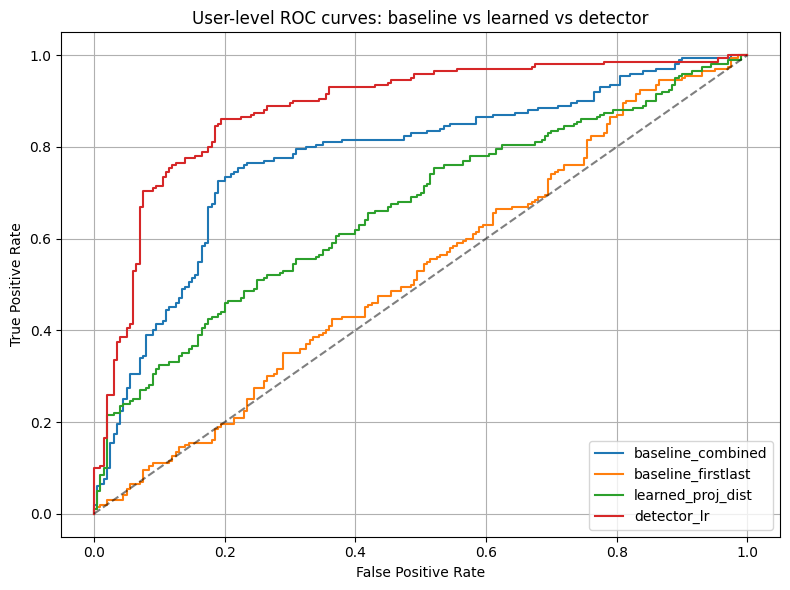

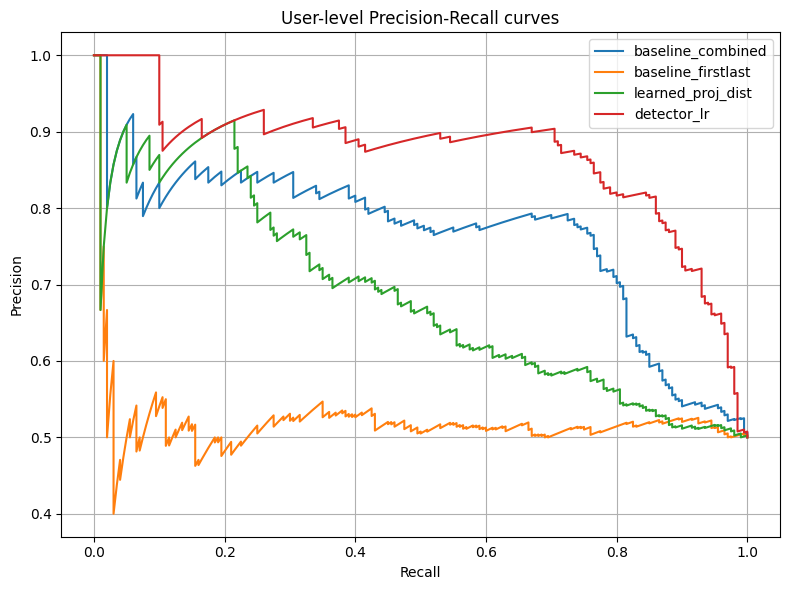

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve

plot_methods = {
    'baseline_combined': scores_user['baselines']['combined'],
    'baseline_firstlast': scores_user['baselines']['firstlast'],
    'learned_proj_dist': scores_user['learned'],
    'detector_lr': scores_user['detector']
}

y_true_arr = np.array(y_true_user)

plt.figure(figsize=(8,6))
for name, sc in plot_methods.items():
    sc = np.array(sc)
    fpr, tpr, _ = roc_curve(y_true_arr, sc)
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1],[0,1],'k--',alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('User-level ROC curves: baseline vs learned vs detector')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
for name, sc in plot_methods.items():
    sc = np.array(sc)
    precision, recall, _ = precision_recall_curve(y_true_arr, sc)
    plt.plot(recall, precision, label=name)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('User-level Precision-Recall curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\anike\AppData\Local\Temp\ipykernel_4556\1241084375.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(user_metrics_df['method'], rotation=45, ha='right')
C:\Users\anike\AppData\Local\Temp\ipykernel_4556\1241084375.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(user_metrics_df['method'], rotation=45, ha='right')
C:\Users\anike\AppData\Local\Temp\ipykernel_4556\1241084375.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(user_metrics_df['method'], rotation=45, ha='right')


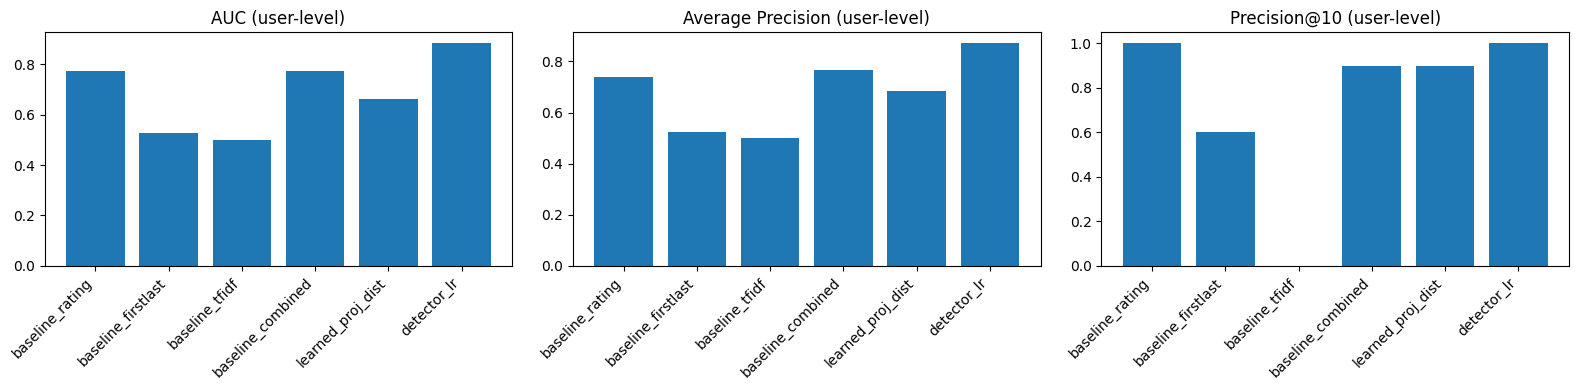

In [ ]:
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(16,4))

# AUC
axes[0].bar(user_metrics_df['method'], user_metrics_df['auc'])
axes[0].set_title('AUC (user-level)')
axes[0].set_xticklabels(user_metrics_df['method'], rotation=45, ha='right')

# AP
axes[1].bar(user_metrics_df['method'], user_metrics_df['ap'])
axes[1].set_title('Average Precision (user-level)')
axes[1].set_xticklabels(user_metrics_df['method'], rotation=45, ha='right')

axes[2].bar(user_metrics_df['method'], user_metrics_df['p@10'])
axes[2].set_title('Precision@10 (user-level)')
axes[2].set_xticklabels(user_metrics_df['method'], rotation=45, ha='right')

plt.tight_layout()
plt.show()


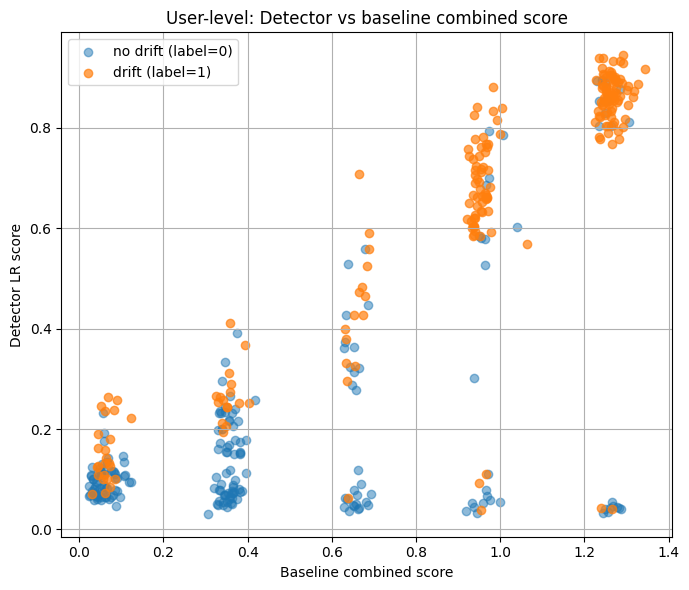

In [ ]:
import numpy as np

det_scores = np.array(scores_user['detector'])
comb_scores = np.array(scores_user['baselines']['combined'])
labels = np.array(y_true_user)

plt.figure(figsize=(7,6))
pos = labels == 1
neg = labels == 0
plt.scatter(comb_scores[neg], det_scores[neg], alpha=0.5, label='no drift (label=0)')
plt.scatter(comb_scores[pos], det_scores[pos], alpha=0.7, label='drift (label=1)')
plt.xlabel('Baseline combined score')
plt.ylabel('Detector LR score')
plt.title('User-level: Detector vs baseline combined score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Simple distance visualizations

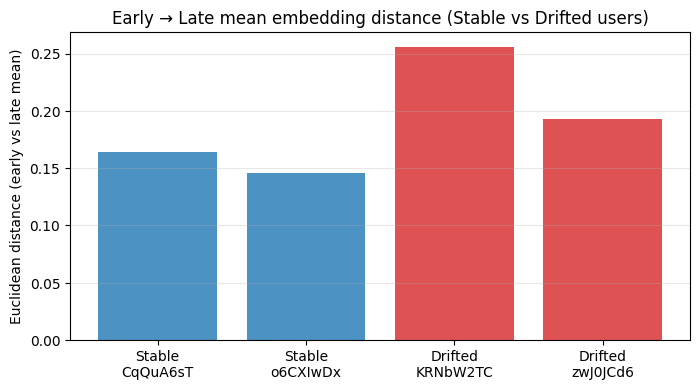

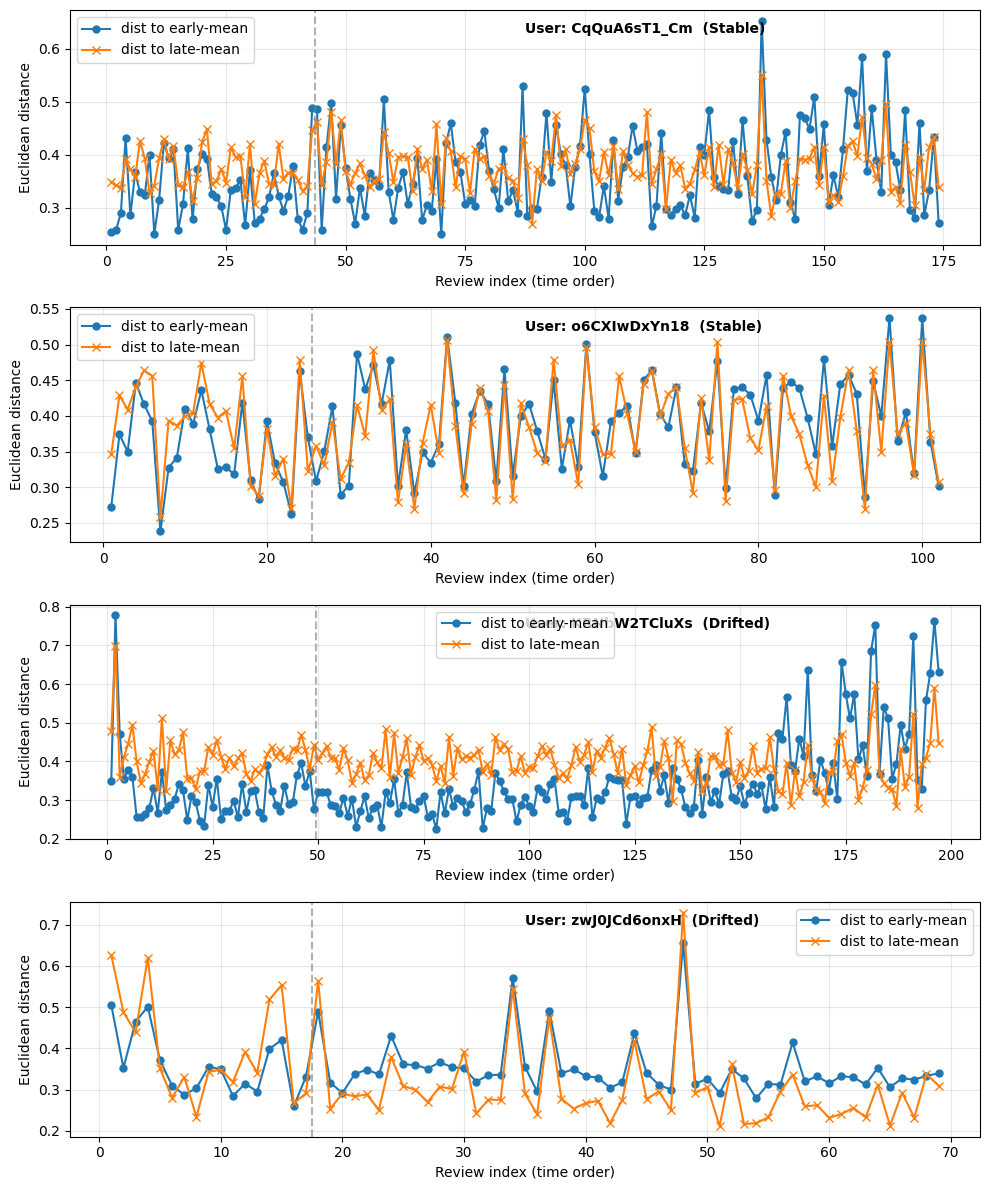

Anchor user: CqQuA6sT1_Cm  (anchor idx=87)
Distance Anchor→Positive (same user, nearby): 0.4506
Distance Anchor→Negative (different user):     0.5144


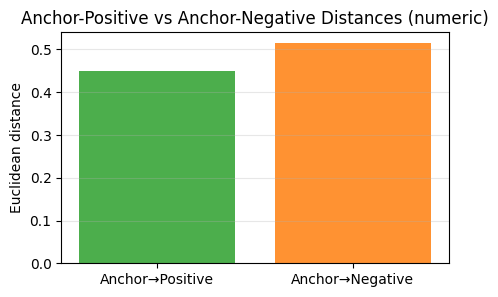

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def to_array(x):
    return np.asarray(x, dtype=float)

def mean_window_embeddings(embs, k_frac=0.25):
    """Return early_mean, late_mean given embeddings array (n x d)."""
    n = len(embs)
    if n < 4:
        return None, None
    k = max(2, int(n * k_frac))
    early = embs[:k].mean(axis=0)
    late  = embs[-k:].mean(axis=0)
    return early, late

def euclid(a, b):
    return np.linalg.norm(a - b)

stable_users  = drift_summary_df.sort_values("drift_score").head(2)['user_id'].tolist()
drifted_users = drift_summary_df.sort_values("drift_score", ascending=False).head(2)['user_id'].tolist()
demo_users = stable_users + drifted_users
demo_labels = ["Stable"]*len(stable_users) + ["Drifted"]*len(drifted_users)

user_distances = []
valid_users = []
for uid, lab in zip(demo_users, demo_labels):
    u_df = df_sample[df_sample['user_id'] == uid].sort_values('date')
    embs = np.vstack(u_df['embedding'].apply(to_array).values) if len(u_df) > 0 else None
    if embs is None or len(embs) < 4:
        print(f"Skipping user {uid} (insufficient reviews).")
        continue
    early_mean, late_mean = mean_window_embeddings(embs)
    if early_mean is None:
        continue
    d = euclid(early_mean, late_mean)
    user_distances.append((uid, lab, d, embs))
    valid_users.append(uid)

if len(user_distances) == 0:
    raise RuntimeError("No valid demo users found with >=4 reviews. Adjust selection or thresholds.")

plt.figure(figsize=(8,4))
xs = [f"{lab}\n{uid[:8]}" for uid, lab, d, _ in user_distances]
vals = [d for _,_,d,_ in user_distances]
colors = ['C0' if lab=='Stable' else 'C3' for _,lab,_,_ in user_distances]
plt.bar(xs, vals, color=colors, alpha=0.8)
plt.ylabel("Euclidean distance (early vs late mean)")
plt.title("Early → Late mean embedding distance (Stable vs Drifted users)")
plt.grid(axis='y', alpha=0.3)
plt.show()

n_users = len(user_distances)
fig, axes = plt.subplots(n_users, 1, figsize=(10, 3*n_users), sharex=False)
if n_users == 1:
    axes = [axes]

for ax, (uid, lab, d, embs) in zip(axes, user_distances):
    n = embs.shape[0]
    early_mean, late_mean = mean_window_embeddings(embs)
    dist_to_early = np.linalg.norm(embs - early_mean[None,:], axis=1)
    dist_to_late  = np.linalg.norm(embs - late_mean[None,:], axis=1)
    idxs = np.arange(1, n+1)
    ax.plot(idxs, dist_to_early, '-o', label='dist to early-mean', markersize=5)
    ax.plot(idxs, dist_to_late, '-x', label='dist to late-mean', markersize=6)
    k = max(2, int(n * 0.25))
    ax.axvline(k + 0.5, color='gray', linestyle='--', alpha=0.6)
    ax.text(0.5, 0.9, f"User: {uid[:12]}  ({lab})", transform=ax.transAxes, fontsize=10, weight='bold')
    ax.set_xlabel("Review index (time order)")
    ax.set_ylabel("Euclidean distance")
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

demo_user = user_distances[0][0]
u_embs = user_distances[0][3]
n = u_embs.shape[0]
if n < 5:
    print("Not enough reviews for anchor demo.")
else:
    anchor_idx = n // 2
    anchor = u_embs[anchor_idx]
    positive = u_embs[anchor_idx + 1] if anchor_idx + 1 < n else u_embs[anchor_idx - 1]
    neg_row = df_sample[df_sample['user_id'] != demo_user].iloc[0]
    negative = to_array(neg_row['embedding'])

    d_ap = euclid(anchor, positive)
    d_an = euclid(anchor, negative)

    print(f"Anchor user: {demo_user[:12]}  (anchor idx={anchor_idx})")
    print(f"Distance Anchor→Positive (same user, nearby): {d_ap:.4f}")
    print(f"Distance Anchor→Negative (different user):     {d_an:.4f}")

    plt.figure(figsize=(5,3))
    plt.bar(['Anchor→Positive','Anchor→Negative'], [d_ap, d_an], color=['C2','C1'], alpha=0.85)
    plt.title("Anchor-Positive vs Anchor-Negative Distances (numeric)")
    plt.ylabel("Euclidean distance")
    plt.grid(axis='y', alpha=0.3)
    plt.show()